In [4]:
from elevenlabs import generate
from IPython.display import Audio

# Replace 'output.mp3' with the path to your saved audio file

answer='[Example]: Take advantage of the low emission period by running your dishwasher or washing machine during this time. This helps optimize energy usage while reducing your impact on the environment.'
generate_voice =generate(text=answer, voice="Callum", model="eleven_multilingual_v1", output_format = "mp3_44100_128", api_key='deee60bf408a983ffc09e2d1d90ef260')

Audio(data=generate_voice)



In [1]:
import logging
import os
import pandas as pd
from telegram import Update, ReplyKeyboardMarkup
from telegram.ext import (
    Application,
    CommandHandler,
    MessageHandler,
    filters,
    ContextTypes,
    ConversationHandler,
    CallbackContext,
)
from elevenlabs import generate
from subs.energy_api import *
from subs.openai_script import *
from subs.telegram_func import *
from dotenv import load_dotenv

# add vars to azure
# Load environment variables from .env file
load_dotenv()
Telegram_energy_api = os.environ.get("Telegram_energy_api")
CHANNEL_ID_FOR_FEEDBACK = os.environ.get("CHANNEL_ID_FOR_FEEDBACK")
ELEVEN_API_KEY = os.environ.get("ELEVEN_API_KEY")





/var/folders/n8/5rf_2zc91lx1ffhm5t27hrsw0000gn/T/ipykernel_4502/1536976505.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [ ]:


# Proceed with your existing logic here...
df_carbon_forecast_indexed = carbon_api_forecast()
co2_stats_prior_day, df_carbon_intensity_recent = carbon_api_intensity()
# Check if either API call failed


In [2]:
df_carbon_forecast_indexed

,FieldName,Region,Value
EffectiveTime,,,
2024-02-22 23:30:00,CO2_INTENSITY_FORECAST,ALL,139.8178


In [3]:

df_ = status_classification(df_carbon_forecast_indexed, co2_stats_prior_day)
# data analysis & adding category per hours


In [4]:
len(df_)

1

In [4]:
summary_text, df_with_trend = find_optimized_relative_periods(df_)


In [5]:
df_with_trend

,FieldName,Region,Value,status_compared_to_yesterday,status_compared_to_EU
EffectiveTime,,,,,
2024-02-22 23:30:00,CO2_INTENSITY_FORECAST,ALL,139.8178,low,low


In [4]:
if df_with_trend is not None:
    print('s')
else:
    print('b')    


s


In [6]:

today_date = df_with_trend.index[0].strftime("%d/%m/%Y")
eu_summary_text = optimize_categorize_periods(df_with_trend)
quantile_summary_text, _ = find_optimized_relative_periods(
    df_with_trend
)  # Generate this based on your DataFrame

prompt = create_combined_gpt_prompt(
    today_date, eu_summary_text, quantile_summary_text
)
gpt_recom = opt_gpt_summarise(prompt)

/Users/saeed/Documents/GitHub/telegram-energy-api/subs/openai_script.py:40: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  for category, group in df.groupby(["category", "group"]):


In [7]:
gpt_recom

"📋 CO2 Emission Brief & Energy Efficiency Guide:\n\n- 🇪🇺 EU Standards Forecast: Low Emission at 23:30\n- 🔍 Data Trend Schedule: Data trend analysis not available.\n- 💡 Energy-Saving Actions:\n   - Low Emission Periods: During low emission periods, such as at 23:30, you can take advantage of running energy-intensive appliances like washing machines or dishwashers without worrying too much about their environmental impact. This is a good time to catch up on laundry or cleaning tasks.\n   - Medium Emission Periods: Since specific medium emission periods are not identified, it's advisable to practice general energy-saving habits regardless of the time of day. For example, you can reduce energy consumption by turning off lights when not in use, unplugging electronics, or adjusting your thermostat to conserve energy.\n   - High Emission Periods: When facing high emission periods, it's essential to be mindful of your energy consumption. Consider minimizing the use of energy-intensive applianc

In [8]:
start_keyword = "- 💡 Energy-Saving Actions:"
end_keywords = ["📋", "- 🇪🇺", "- 🔍", "- 💡"]  # Add possible start of next sections if format varies
end_keyword = next((kw for kw in end_keywords if kw in gpt_recom[gpt_recom.find(start_keyword):]), None)

# Find start and end positions
start_pos = gpt_recom.find(start_keyword)
end_pos = gpt_recom.find(end_keyword, start_pos + 1) if end_keyword else len(gpt_recom)

# Extract the section
energy_saving_actions = gpt_recom[start_pos:end_pos].strip()

print(energy_saving_actions)

- 💡 Energy-Saving Actions:
   - Low Emission Periods: During the low emission period from 22:30 to 23:30, you can use energy-intensive appliances like washing machines, dishwashers, and dryers. Consider doing laundry or running the dishwasher during this time to optimize energy usage.
   
   - Medium Emission Periods: For the medium emission period around 22:30, focus on reducing energy consumption by turning off lights in unoccupied rooms, unplugging electronics not in use, and adjusting thermostats to conserve energy.
   
   - High Emission Periods: During the high emission period at 23:30, it's advisable to avoid unnecessary energy consumption. You can save energy by switching to energy-efficient light bulbs, reducing standby power consumption by unplugging devices, and lowering the thermostat to minimize heating or cooling energy


In [7]:
generate_voice =generate(text=gpt_recom, voice="Callum", model="eleven_multilingual_v1", output_format = "mp3_44100_128", api_key='deee60bf408a983ffc09e2d1d90ef260')

Audio(data=generate_voice)

In [9]:
start_pos

348

In [11]:
end_pos

-1

In [9]:

def round_time(dt):
    # Round minutes to the nearest 15
    new_minute = (dt.minute // 15) * 15
    return dt.replace(minute=new_minute, second=0, microsecond=0)
    
def format_date(dt):
    return dt.strftime("%d-%b-%Y").lower() + "+" + dt.strftime("%H%%3A%M")


# Current date and time, rounded to the nearest 15 minutes
now = round_time(datetime.datetime.now())

# Start time (same time yesterday, rounded to the nearest 15 minutes)
yesterday = now - datetime.timedelta(days=1)
startDateTime = format_date(yesterday)

# End time (current time, rounded to the nearest 15 minutes)
endDateTime = format_date(now)

area = [
    "CO2Stats",
    "generationactual",
    "co2emission",
    "co2intensity",
    "interconnection",
    "SnspAll",
    "frequency",
    "demandactual",
    "windactual",
    "fuelMix"
]
region = ["ROI", "NI", "ALL"]
Rows = []


In [7]:
del Rows,row

In [10]:

url = f"http://smartgriddashboard.eirgrid.com/DashboardService.svc/data?area={area[9]}&region={region[2]}&datefrom={now}&dateto={now}"
response = requests.get(url)
Rs = json.loads(response.text)["Rows"]
for row in Rs:
    Rows.append(row)

fuel_mix_eirgrid = pd.DataFrame(Rows)

# # Convert 'EffectiveTime' to datetime and set as index
# df_carbon_intensity_day_before["EffectiveTime"] = pd.to_datetime(
#     df_carbon_intensity_day_before["EffectiveTime"], format="%d-%b-%Y %H:%M:%S"
# )
# df_carbon_intensity_indexed = df_carbon_intensity_day_before.set_index(
#     "EffectiveTime"
# )

# last_value_index_co_intensity = df_carbon_intensity_indexed[
#     "Value"
# ].last_valid_index()

# # Select rows up to the row before the last NaN
# df_carbon_intensity_recent = df_carbon_intensity_indexed.loc[
#     :last_value_index_co_intensity
# ]

# df_carbon_intensity_recent["Value"] = df_carbon_intensity_recent[
#     "Value"
# ].interpolate()

In [11]:
fuel_mix_eirgrid

,EffectiveTime,FieldName,Region,Value
0,25-Feb-2024 00:30:00,FUEL_COAL,ALL,3242.92
1,25-Feb-2024 00:30:00,FUEL_GAS,ALL,64155.66
2,25-Feb-2024 00:30:00,FUEL_NET_IMPORT,ALL,16240.82
3,25-Feb-2024 00:30:00,FUEL_OTHER_FOSSIL,ALL,5298.15
4,25-Feb-2024 00:30:00,FUEL_RENEW,ALL,25774.88


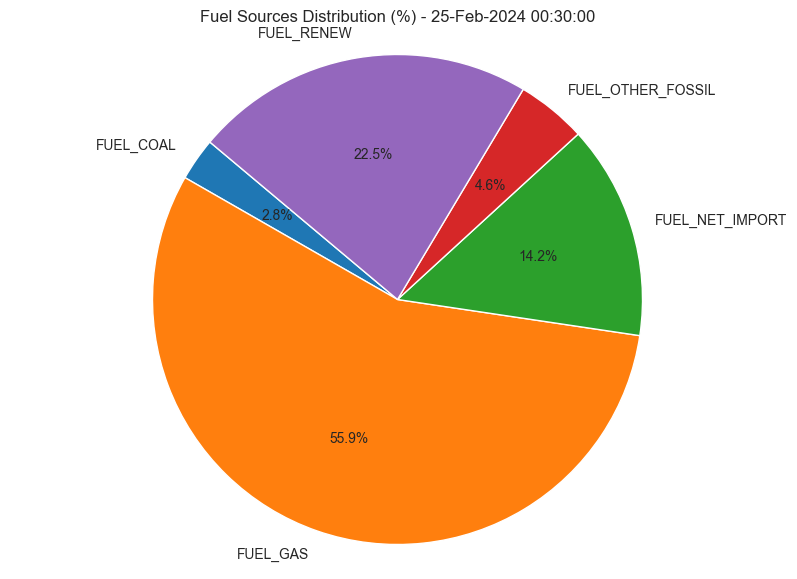

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# # Data
# data = {
#     "EffectiveTime": ["25-Feb-2024 00:30:00"]*5,
#     "FieldName": ["FUEL_COAL", "FUEL_GAS", "FUEL_NET_IMPORT", "FUEL_OTHER_FOSSIL", "FUEL_RENEW"],
#     "Region": ["ALL"]*5,
#     "Value": [3242.92, 64155.66, 16240.82, 5298.15, 25774.88]
# }

# # Creating DataFrame
# df = pd.DataFrame(data)
sns.set_style("darkgrid", {"axes.facecolor": ".9"})

# Plotting Pie Chart
plt.figure(figsize=(10, 7))
plt.pie(fuel_mix_eirgrid['Value'], labels=fuel_mix_eirgrid['FieldName'], autopct='%1.1f%%', startangle=140)
plt.title('Fuel Sources Distribution (%) - 25-Feb-2024 00:30:00')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()


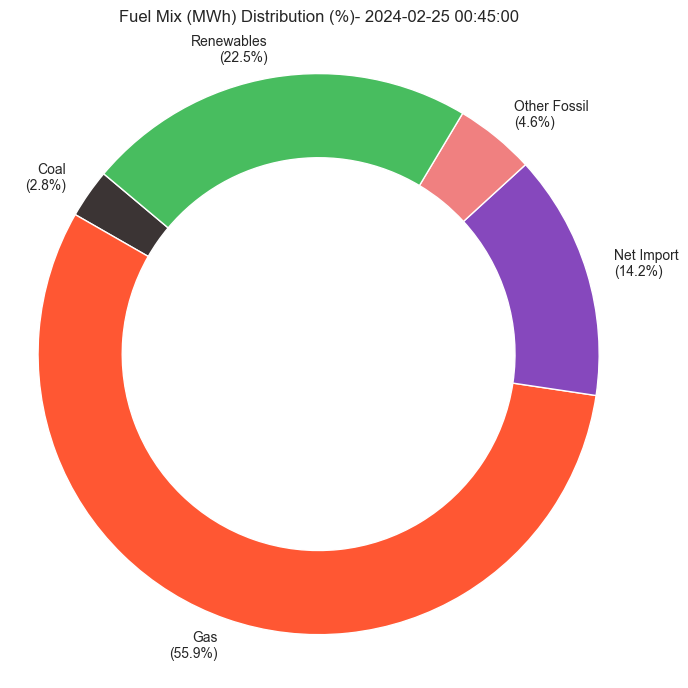

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

# Adjusting colors to be less vibrant (more pastel-like)
pastel_colors = {
    "FUEL_COAL": "#3B3434",  # Coal - less vibrant gray
    "FUEL_GAS": "#FF5733",  # Gas - less vibrant orange
    "FUEL_NET_IMPORT": "#8648BD",  # Net Import - less vibrant blue
    "FUEL_OTHER_FOSSIL": "#F08080",  # Other Fossil - less vibrant red
    "FUEL_RENEW": "#48BD5F"  # Renewables - less vibrant green
}

# Mapping the pastel colors to the dataframe's FieldName
pastel_pie_colors = [pastel_colors[field] for field in fuel_mix_eirgrid['FieldName']]

# Custom labels with descriptive names and percentages
descriptive_names = {
    "FUEL_COAL": "Coal",
    "FUEL_GAS": "Gas",
    "FUEL_NET_IMPORT": "Net Import",
    "FUEL_OTHER_FOSSIL": "Other Fossil",
    "FUEL_RENEW": "Renewables"
}
total = sum(fuel_mix_eirgrid['Value'])
percentages = [(value / total) * 100 for value in fuel_mix_eirgrid['Value']]
custom_labels = [f'{descriptive_names[name]}\n({percent:.1f}%)' for name, percent in zip(fuel_mix_eirgrid['FieldName'], percentages)]

# Plotting Donut Chart with custom, less vibrant colors and descriptive labels
plt.figure(figsize=(7, 7))
plt.pie(fuel_mix_eirgrid['Value'], labels=custom_labels, startangle=140, colors=pastel_pie_colors, wedgeprops=dict(width=0.3))
plt.title(f'Fuel Mix (MWh) Distribution (%)- {now}')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()


In [24]:
now = round_time(datetime.datetime.now())

# Start time (same time yesterday, rounded to the nearest 15 minutes)
yesterday = now - datetime.timedelta(days=1)
startDateTime = format_date(yesterday)

# End time (current time, rounded to the nearest 15 minutes)
endDateTime = format_date(now)

In [3]:


df_carbon_intensity_day_before = eirgrid_api('co2intensity','ALL',startDateTime,endDateTime)

In [4]:
df_carbon_intensity_day_before

,EffectiveTime,FieldName,Region,Value
0,24-Feb-2024 01:15:00,CO2_INTENSITY,ALL,241.0
1,24-Feb-2024 01:30:00,CO2_INTENSITY,ALL,240.0
2,24-Feb-2024 01:45:00,CO2_INTENSITY,ALL,231.0
3,24-Feb-2024 02:00:00,CO2_INTENSITY,ALL,224.0
4,24-Feb-2024 02:15:00,CO2_INTENSITY,ALL,216.0
...,...,...,...,...
92,25-Feb-2024 00:15:00,CO2_INTENSITY,ALL,193.0
93,25-Feb-2024 00:30:00,CO2_INTENSITY,ALL,194.0
94,25-Feb-2024 00:45:00,CO2_INTENSITY,ALL,197.0
95,25-Feb-2024 01:00:00,CO2_INTENSITY,ALL,NaN


In [3]:
fuel_mix_eirgrid = fuel_mix()

In [14]:
fuel_mix_eirgrid

,EffectiveTime,FieldName,Region,Value
0,25-Feb-2024 02:00:00,Coal,ALL,3250.43
1,25-Feb-2024 02:00:00,Gas,ALL,63221.75
2,25-Feb-2024 02:00:00,Net Import,ALL,16092.92
3,25-Feb-2024 02:00:00,Other Fossil,ALL,5266.07
4,25-Feb-2024 02:00:00,Renewables,ALL,26711.57


In [20]:
fuel_mix_eirgrid

,EffectiveTime,FieldName,Region,Value,Percentage
0,25-Feb-2024 02:00:00,Coal,ALL,3250.43,2.837744
1,25-Feb-2024 02:00:00,Gas,ALL,63221.75,55.194899
2,25-Feb-2024 02:00:00,Net Import,ALL,16092.92,14.049708
3,25-Feb-2024 02:00:00,Other Fossil,ALL,5266.07,4.597472
4,25-Feb-2024 02:00:00,Renewables,ALL,26711.57,23.320177


In [21]:
# Correcting the list comprehension to match the data structure
fuel_mix_details = "\n".join([f"- {fuel_mix_eirgrid['FieldName'][i]}: {fuel_mix_eirgrid['Value'][i]} MWh ({fuel_mix_eirgrid['Percentage'][i]:.1f}%)" 
                              for i in range(len(fuel_mix_eirgrid['FieldName']))])


In [22]:
fuel_mix_details

'- Coal: 3250.43 MWh (2.8%)\n- Gas: 63221.75 MWh (55.2%)\n- Net Import: 16092.92 MWh (14.0%)\n- Other Fossil: 5266.07 MWh (4.6%)\n- Renewables: 26711.57 MWh (23.3%)'

In [23]:
def create_fuel_mix_prompt(date, fuel_mix_data):
    # Preparing fuel mix data string
    # Correcting the list comprehension to match the data structure
    fuel_mix_details = "\n".join([f"- {fuel_mix_eirgrid['FieldName'][i]}: {fuel_mix_eirgrid['Value'][i]} MWh ({fuel_mix_eirgrid['Percentage'][i]:.1f}%)" 
                              for i in range(len(fuel_mix_eirgrid['FieldName']))])

    prompt_text = (
        f"📅 Date: {date}\n"
        f"🔋 Fuel Mix Data (MWh & Percentage):\n\n"
        f"{fuel_mix_details}\n\n"
        "Based on the above data, write a short report about the current status of the energy system. "
        "Please summarize the contribution of each fuel source to the overall mix and any notable trends. "
        "Use the following structure for your response, incorporating the specified emojis to highlight each fuel source:\n\n"
        "📋 Fuel Mix Status:\n"
        "- 🪨 Coal: [percentage]%\n"
        "- 🌬️ Gas: [percentage]%\n"
        "- ⚡ Net Import: [percentage]%\n"
        "- 🛢️ Other Fossil: [percentage]%\n"
        "- 🌿 Renewables: [percentage]%\n\n"
        "Note: Replace [percentage] with the actual percentages from the data. "
        "Avoid using asterisks (*) in your response and stick to the names and format provided."
    )

    return prompt_text


In [25]:
test= create_fuel_mix_prompt(now, fuel_mix_eirgrid)


In [26]:
test

'📅 Date: 2024-02-25 02:30:00\n🔋 Fuel Mix Data (MWh & Percentage):\n\n- Coal: 3250.43 MWh (2.8%)\n- Gas: 63221.75 MWh (55.2%)\n- Net Import: 16092.92 MWh (14.0%)\n- Other Fossil: 5266.07 MWh (4.6%)\n- Renewables: 26711.57 MWh (23.3%)\n\nBased on the above data, write a short report about the current status of the energy system. Please summarize the contribution of each fuel source to the overall mix and any notable trends. Use the following structure for your response, incorporating the specified emojis to highlight each fuel source:\n\n📋 Fuel Mix Status:\n- 🪨 Coal: [percentage]%\n- 🌬️ Gas: [percentage]%\n- ⚡ Net Import: [percentage]%\n- 🛢️ Other Fossil: [percentage]%\n- 🌿 Renewables: [percentage]%\n\nNote: Replace [percentage] with the actual percentages from the data. Avoid using asterisks (*) in your response and stick to the names and format provided.'

In [48]:
test

"📊 Given the fuel mix summary at 2024-02-25 01:15:00, write a short report about the status of the system using Fuel Mix Data:\n\n{'FieldName': {0: 'Coal', 1: 'Gas', 2: 'Net Import', 3: 'Other Fossil', 4: 'Renewables'}, 'Value': {0: 3277.26, 1: 64117.25, 2: 16426.44, 3: 5340.13, 4: 26567.28}, 'Percentage': {0: 2.831855562456774, 1: 55.403230461401165, 2: 14.193962482489168, 3: 4.614365916876382, 4: 22.95658557677651}}\n\n👉 Please use the following format for your response and avoid using * in your response: \n\n 📋 Fuel Mix Status:\n\n\n"

In [27]:
opt_gpt_summarise(test)

'📋 Fuel Mix Status:\n- 🪨 Coal: 2.8%\n- 🌬️ Gas: 55.2%\n- ⚡ Net Import: 14.0%\n- 🛢️ Other Fossil: 4.6%\n- 🌿 Renewables: 23.3%\n\nThe current energy mix shows a significant reliance on gas, accounting for 55.2% of the total generation. Renewables make up a notable portion at 23.3%, showcasing a strong commitment to sustainable energy sources. Coal remains the smallest contributor at 2.8%, indicating a continued shift away from coal-fired generation. Net imports and other fossil fuels provide support to the grid, ensuring a diverse and balanced energy supply.'

In [15]:
total = sum(fuel_mix_eirgrid['Value'])
percentages = [(value / total) * 100 for value in fuel_mix_eirgrid['Value']]

In [16]:
fuel_mix_eirgrid['Percentage'] = percentages

In [45]:
fuel_mix_eirgrid

,EffectiveTime,FieldName,Region,Value,Percentage
0,25-Feb-2024 01:15:00,Coal,ALL,3277.26,2.831856
1,25-Feb-2024 01:15:00,Gas,ALL,64117.25,55.403230
2,25-Feb-2024 01:15:00,Net Import,ALL,16426.44,14.193962
3,25-Feb-2024 01:15:00,Other Fossil,ALL,5340.13,4.614366
4,25-Feb-2024 01:15:00,Renewables,ALL,26567.28,22.956586


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Adjusting colors to be less vibrant (more pastel-like)
pastel_colors = {
    "FUEL_COAL": "#3B3434",  # Coal - less vibrant gray
    "FUEL_GAS": "#FF5733",  # Gas - less vibrant orange
    "FUEL_NET_IMPORT": "#8648BD",  # Net Import - less vibrant blue
    "FUEL_OTHER_FOSSIL": "#F08080",  # Other Fossil - less vibrant red
    "FUEL_RENEW": "#48BD5F"  # Renewables - less vibrant green
}

# Mapping the pastel colors to the dataframe's FieldName
pastel_pie_colors = [pastel_colors[field] for field in fuel_mix_eirgrid['FieldName']]

# Custom labels with descriptive names and percentages
descriptive_names = {
    "FUEL_COAL": "Coal",
    "FUEL_GAS": "Gas",
    "FUEL_NET_IMPORT": "Net Import",
    "FUEL_OTHER_FOSSIL": "Other Fossil",
    "FUEL_RENEW": "Renewables"
}
total = sum(fuel_mix_eirgrid['Value'])
percentages = [(value / total) * 100 for value in fuel_mix_eirgrid['Value']]
custom_labels = [f'{descriptive_names[name]}\n({percent:.1f}%)' for name, percent in zip(fuel_mix_eirgrid['FieldName'], percentages)]

# Plotting Donut Chart with custom, less vibrant colors and descriptive labels
plt.figure(figsize=(7, 7))
plt.pie(fuel_mix_eirgrid['Value'], labels=custom_labels, startangle=140, colors=pastel_pie_colors, wedgeprops=dict(width=0.3))
plt.title(f'Fuel Mix (MWh) Distribution (%)- {now}')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()


In [28]:
# Adjusting colors to be less vibrant (more pastel-like)
pastel_colors = {
    "Coal": "#3B3434",  # Coal - less vibrant gray
    "Gas": "#FF5733",  # Gas - less vibrant orange
    "Net Import": "#8648BD",  # Net Import - less vibrant blue
    "Other Fossil": "#F08080",  # Other Fossil - less vibrant red
    "Renewables": "#48BD5F",  # Renewables - less vibrant green
}

# Mapping the pastel colors to the dataframe's FieldName
pastel_pie_colors = [
    pastel_colors[field] for field in fuel_mix_eirgrid["FieldName"]]

In [29]:
pastel_pie_colors

['#3B3434', '#FF5733', '#8648BD', '#F08080', '#48BD5F']

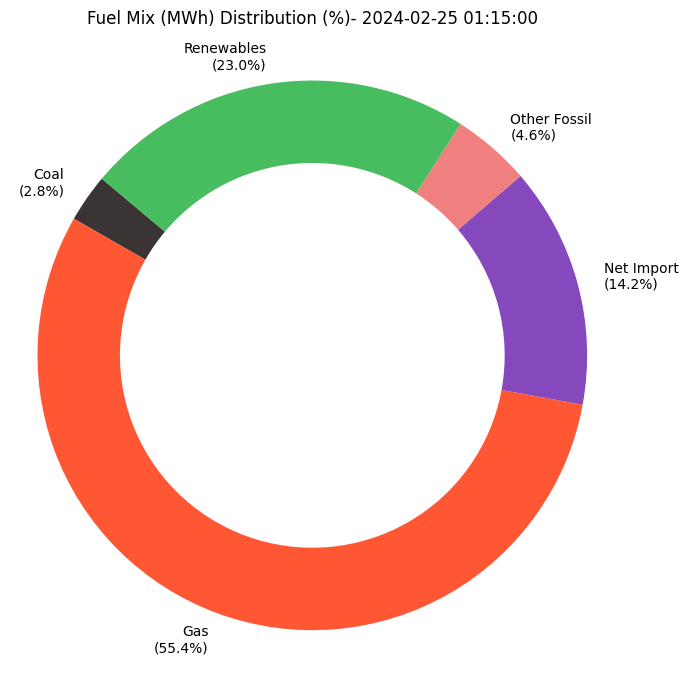

In [64]:
# Adjusting colors to be less vibrant (more pastel-like)
pastel_colors = {
    "Coal": "#3B3434",  # Coal - less vibrant gray
    "Gas": "#FF5733",  # Gas - less vibrant orange
    "Net Import": "#8648BD",  # Net Import - less vibrant blue
    "Other Fossil": "#F08080",  # Other Fossil - less vibrant red
    "Renewables": "#48BD5F"  # Renewables - less vibrant green
}

# Mapping the pastel colors to the dataframe's FieldName
pastel_pie_colors = [pastel_colors[field] for field in fuel_mix_eirgrid['FieldName']]
custom_labels = [f'{row["FieldName"]}\n({row["Percentage"]:.1f}%)' for index, row in fuel_mix_eirgrid.iterrows()]
plt.figure(figsize=(7, 7))
plt.pie(fuel_mix_eirgrid['Value'], labels=custom_labels, startangle=140, colors=pastel_pie_colors, wedgeprops=dict(width=0.3))
plt.title(f'Fuel Mix (MWh) Distribution (%)- {now}')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
plt.show()


In [60]:
[f'{fuel_mix_eirgrid['FieldName']}\n({percent:.1f}%)' for name, percent in zip(fuel_mix_eirgrid['FieldName'], percentages)]


['0            Coal\n1             Gas\n2      Net Import\n3    Other Fossil\n4      Renewables\nName: FieldName, dtype: object\n(2.8%)',
 '0            Coal\n1             Gas\n2      Net Import\n3    Other Fossil\n4      Renewables\nName: FieldName, dtype: object\n(55.4%)',
 '0            Coal\n1             Gas\n2      Net Import\n3    Other Fossil\n4      Renewables\nName: FieldName, dtype: object\n(14.2%)',
 '0            Coal\n1             Gas\n2      Net Import\n3    Other Fossil\n4      Renewables\nName: FieldName, dtype: object\n(4.6%)',
 '0            Coal\n1             Gas\n2      Net Import\n3    Other Fossil\n4      Renewables\nName: FieldName, dtype: object\n(23.0%)']

In [56]:
[print(name,percent) for name, percent in zip(fuel_mix_eirgrid['FieldName'], percentages)]

Coal 2.831855562456774
Gas 55.403230461401165
Net Import 14.193962482489168
Other Fossil 4.614365916876382
Renewables 22.95658557677651


[None, None, None, None, None]

In [59]:
fuel_mix_eirgrid

,EffectiveTime,FieldName,Region,Value,Percentage
0,25-Feb-2024 01:15:00,Coal,ALL,3277.26,2.831856
1,25-Feb-2024 01:15:00,Gas,ALL,64117.25,55.403230
2,25-Feb-2024 01:15:00,Net Import,ALL,16426.44,14.193962
3,25-Feb-2024 01:15:00,Other Fossil,ALL,5340.13,4.614366
4,25-Feb-2024 01:15:00,Renewables,ALL,26567.28,22.956586


In [58]:
descriptive_names

{'FUEL_COAL': 'Coal',
 'FUEL_GAS': 'Gas',
 'FUEL_NET_IMPORT': 'Net Import',
 'FUEL_OTHER_FOSSIL': 'Other Fossil',
 'FUEL_RENEW': 'Renewables'}

In [62]:
custom_labels = [f'{row["FieldName"]}\n({row["Percentage"]:.1f}%)' for index, row in fuel_mix_eirgrid.iterrows()]


In [63]:
custom_labels

['Coal\n(2.8%)',
 'Gas\n(55.4%)',
 'Net Import\n(14.2%)',
 'Other Fossil\n(4.6%)',
 'Renewables\n(23.0%)']

In [ ]:
fuel_mix_eirgrid = fuel_mix()
descriptive_names = {
    "FUEL_COAL": "Coal",
    "FUEL_GAS": "Gas",
    "FUEL_NET_IMPORT": "Net Import",
    "FUEL_OTHER_FOSSIL": "Other Fossil",
    "FUEL_RENEW": "Renewables",
}

fuel_mix_eirgrid["FieldName"] = fuel_mix_eirgrid["FieldName"].map(descriptive_names)

total = sum(fuel_mix_eirgrid["Value"])
percentages = [(value / total) * 100 for value in fuel_mix_eirgrid["Value"]]
fuel_mix_eirgrid["Percentage"] = percentages

now = round_time(datetime.datetime.now())

promopt_for_fuel_mix = create_fuel_mix_prompt(
    now, fuel_mix_eirgrid[["FieldName", "Value", "Percentage"]].to_dict()
)


fuel_mix_response_from_gpt = opt_gpt_summarise(promopt_for_fuel_mix)

# audio_msg = generate_voice(fuel_mix_response_from_gpt)





In [ ]:

# Adjusting colors to be less vibrant (more pastel-like)
pastel_colors = {
    "Coal": "#3B3434",  # Coal - less vibrant gray
    "Gas": "#FF5733",  # Gas - less vibrant orange
    "Net Import": "#8648BD",  # Net Import - less vibrant blue
    "Other Fossil": "#F08080",  # Other Fossil - less vibrant red
    "Renewables": "#48BD5F",  # Renewables - less vibrant green
}

# Mapping the pastel colors to the dataframe's FieldName
pastel_pie_colors = [
    pastel_colors[field] for field in fuel_mix_eirgrid["FieldName"]
]
custom_labels = [
    f'{row["FieldName"]}\n({row["Percentage"]:.1f}%)'
    for index, row in fuel_mix_eirgrid.iterrows()
]
plt.figure(figsize=(7, 7))
plt.pie(
    fuel_mix_eirgrid["Value"],
    labels=custom_labels,
    startangle=140,
    colors=pastel_pie_colors,
    wedgeprops=dict(width=0.3),
)
plt.title(f"Fuel Mix (MWh) Distribution (%)- {now}")
plt.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
# plt.show()
# Save the plot to a BytesIO buffer
buf = BytesIO()
plt.savefig(buf, format="png")
buf.seek(0)
plt.close()  # Make sure to close the plot to free up memory
caption_text = "test"
# Send the photo
chat_id = update.effective_chat.id
await context.bot.send_photo(chat_id=chat_id, photo=buf, caption=caption_text)


In [1]:
import requests, json
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns
import matplotlib.dates as mdates
import numpy as np
from io import BytesIO


def eirgrid_api(area, region, start_time, end_time):
    #     area = [
    #     "CO2Stats",
    #     "generationactual",
    #     "co2emission",
    #     "co2intensity",
    #     "interconnection",
    #     "SnspAll",
    #     "frequency",
    #     "demandactual",
    #     "windactual",
    #     "fuelMix"
    # ]
    #     region = ["ROI", "NI", "ALL"]
    Rows = []
    url = f"http://smartgriddashboard.eirgrid.com/DashboardService.svc/data?area={area}&region={region}&datefrom={start_time}&dateto={end_time}"
    response = requests.get(url)
    Rs = json.loads(response.text)["Rows"]
    for row in Rs:
        Rows.append(row)

    return pd.DataFrame(Rows)

/var/folders/n8/5rf_2zc91lx1ffhm5t27hrsw0000gn/T/ipykernel_2529/1850023881.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [6]:
# Function to round time to the nearest 15 minutes
def round_time(dt):
    # Round minutes to the nearest 15
    new_minute = (dt.minute // 15) * 15
    return dt.replace(minute=new_minute, second=0, microsecond=0)


# Function to format date in a specific format
def format_date(dt):
    return dt.strftime("%d-%b-%Y").lower() + "+" + dt.strftime("%H%%3A%M")


In [18]:
# Current date and time, rounded to the nearest 15 minutes
now = round_time(datetime.datetime.now())

# Start time (same time yesterday, rounded to the nearest 15 minutes)
yesterday = now - datetime.timedelta(days=1)
startDateTime = format_date(yesterday)

# End time (current time, rounded to the nearest 15 minutes)
endDateTime = format_date(now)

# call API to get fuel mix for current time
fuel_mix_eirgrid = eirgrid_api("fuelMix", "ALL", startDateTime, startDateTime)


In [19]:
fuel_mix_eirgrid

,EffectiveTime,FieldName,Region,Value
0,26-Feb-2024 23:00:00,FUEL_COAL,ALL,8084.08
1,26-Feb-2024 23:00:00,FUEL_GAS,ALL,51245.19
2,26-Feb-2024 23:00:00,FUEL_NET_IMPORT,ALL,11567.20
3,26-Feb-2024 23:00:00,FUEL_OTHER_FOSSIL,ALL,4934.83
4,26-Feb-2024 23:00:00,FUEL_RENEW,ALL,46444.11


In [21]:
fuel_mix_eirgrid.loc[fuel_mix_eirgrid['FieldName'] == 'FUEL_NET_IMPORT', 'Value'] = -500


In [33]:
fuel_mix_eirgrid.loc[:,['FieldName','Value']]

,FieldName,Value
0,Coal,8084.08
1,Gas,51245.19
2,Net Import,-500.00
3,Other Fossil,4934.83
4,Renewables,46444.11


In [23]:

descriptive_names = {
    "FUEL_COAL": "Coal",
    "FUEL_GAS": "Gas",
    "FUEL_NET_IMPORT": "Net Import",
    "FUEL_OTHER_FOSSIL": "Other Fossil",
    "FUEL_RENEW": "Renewables",
}

fuel_mix_eirgrid["FieldName"] = fuel_mix_eirgrid["FieldName"].map(
    descriptive_names
)

fuel_mix_eirgrid['ValueForPercentage'] = fuel_mix_eirgrid['Value'].apply(lambda x: max(x, 0))
total_for_percentage = sum(fuel_mix_eirgrid['ValueForPercentage'])
percentages = [(value / total_for_percentage) * 100 if value > 0 else 0 for value in fuel_mix_eirgrid['ValueForPercentage']]
fuel_mix_eirgrid["Percentage"] = percentages

if fuel_mix_eirgrid.loc[fuel_mix_eirgrid['FieldName'] == 'Net Import', 'Value'].values[0] <0:
    net_import='export'
else:
    net_import = 'importing'
        


In [28]:
[fuel_mix_eirgrid['FieldName'] == 'FUEL_NET_IMPORT', 'Value']

[0    False
 1    False
 2    False
 3    False
 4    False
 Name: FieldName, dtype: bool,
 'Value']

In [40]:
fuel_mix_eirgrid.drop('')

,EffectiveTime,FieldName,Region,Value,ValueForPercentage,Percentage
0,26-Feb-2024 23:00:00,Coal,ALL,8084.08,8084.08,7.302150
1,26-Feb-2024 23:00:00,Gas,ALL,51245.19,51245.19,46.288518
2,26-Feb-2024 23:00:00,Net Import,ALL,-500.00,0.00,0.000000
3,26-Feb-2024 23:00:00,Other Fossil,ALL,4934.83,4934.83,4.457510
4,26-Feb-2024 23:00:00,Renewables,ALL,46444.11,46444.11,41.951821


In [ ]:
fuel_mix_eirgrid.loc[fuel_mix_eirgrid['FieldName'] == 'FUEL_NET_IMPORT', 'Value'] = -11567.20


In [38]:
fuel_mix_eirgrid.loc[fuel_mix_eirgrid['FieldName'] == 'Net Import', 'Value'].values[0]

-500.0

In [39]:
fuel_mix_eirgrid

,EffectiveTime,FieldName,Region,Value,ValueForPercentage,Percentage
0,26-Feb-2024 23:00:00,Coal,ALL,8084.08,8084.08,7.302150
1,26-Feb-2024 23:00:00,Gas,ALL,51245.19,51245.19,46.288518
2,26-Feb-2024 23:00:00,Net Import,ALL,-500.00,0.00,0.000000
3,26-Feb-2024 23:00:00,Other Fossil,ALL,4934.83,4934.83,4.457510
4,26-Feb-2024 23:00:00,Renewables,ALL,46444.11,46444.11,41.951821


In [1]:
import logging
import os
import pandas as pd
from telegram import Update, ReplyKeyboardMarkup
from telegram.ext import (
    Application,
    CommandHandler,
    MessageHandler,
    filters,
    ContextTypes,
    ConversationHandler,
    CallbackContext,
)
from elevenlabs import generate
from subs.energy_api import *
from subs.openai_script import *
from subs.telegram_func import (
    telegram_carbon_intensity,
    telegram_fuel_mix,
)
from dotenv import load_dotenv

# add vars to azure
# Load environment variables from .env file
load_dotenv()
Telegram_energy_api = os.environ.get("Telegram_energy_api")
CHANNEL_ID_FOR_FEEDBACK = os.environ.get("CHANNEL_ID_FOR_FEEDBACK")
ELEVEN_API_KEY = os.environ.get("ELEVEN_API_KEY")

/var/folders/n8/5rf_2zc91lx1ffhm5t27hrsw0000gn/T/ipykernel_3671/2961501540.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
fuel_mix_eirgrid, net_import_status = fuel_mix()


In [2]:

now = round_time(datetime.datetime.now())

In [4]:
fuel_mix_eirgrid

,EffectiveTime,FieldName,Region,Value,ValueForPercentage,Percentage
0,27-Feb-2024 00:15:00,Coal,ALL,8257.29,8257.29,6.738314
1,27-Feb-2024 00:15:00,Gas,ALL,51987.61,51987.61,42.424188
2,27-Feb-2024 00:15:00,Net Import,ALL,12098.88,12098.88,9.873221
3,27-Feb-2024 00:15:00,Other Fossil,ALL,4959.45,4959.45,4.047130
4,27-Feb-2024 00:15:00,Renewables,ALL,45239.15,45239.15,36.917147


In [4]:
fuel_mix_eirgrid.loc[fuel_mix_eirgrid['FieldName'] == 'Net Import', 'Value'] = -11567.20
fuel_mix_eirgrid.loc[fuel_mix_eirgrid['FieldName'] == 'Net Import', 'ValueForPercentage'] = 0
fuel_mix_eirgrid.loc[fuel_mix_eirgrid['FieldName'] == 'Net Import', 'Percentage'] = 0


In [5]:
fuel_mix_eirgrid

,EffectiveTime,FieldName,Region,Value,ValueForPercentage,Percentage
0,27-Feb-2024 00:00:00,Coal,ALL,8222.31,8222.31,6.711899
1,27-Feb-2024 00:00:00,Gas,ALL,51852.59,51852.59,42.327439
2,27-Feb-2024 00:00:00,Net Import,ALL,-11567.20,0.00,0.000000
3,27-Feb-2024 00:00:00,Other Fossil,ALL,4954.84,4954.84,4.044652
4,27-Feb-2024 00:00:00,Renewables,ALL,45456.05,45456.05,37.105922


In [3]:
# Assuming df is your DataFrame
data = {
    "EffectiveTime": ["27-Feb-2024 00:00:00", "27-Feb-2024 00:00:00", "27-Feb-2024 00:00:00", "27-Feb-2024 00:00:00", "27-Feb-2024 00:00:00"],
    "FieldName": ["Coal", "Gas", "Net Import", "Other Fossil", "Renewables"],
    "Region": ["ALL", "ALL", "ALL", "ALL", "ALL"],
    "Value": [8222.31, 51852.59, -11567.20, 4954.84, 45456.05],
    "ValueForPercentage": [8222.31, 51852.59, 0.00, 4954.84, 45456.05],
    "Percentage": [6.711899, 42.327439, 0.000000, 4.044652, 37.105922],
}

df = pd.DataFrame(data)

In [4]:
df

,EffectiveTime,FieldName,Region,Value,ValueForPercentage,Percentage
0,27-Feb-2024 00:00:00,Coal,ALL,8222.31,8222.31,6.711899
1,27-Feb-2024 00:00:00,Gas,ALL,51852.59,51852.59,42.327439
2,27-Feb-2024 00:00:00,Net Import,ALL,-11567.20,0.00,0.000000
3,27-Feb-2024 00:00:00,Other Fossil,ALL,4954.84,4954.84,4.044652
4,27-Feb-2024 00:00:00,Renewables,ALL,45456.05,45456.05,37.105922


In [4]:
net_import_status='exporting'

In [6]:
net_import_status

'exporting'

In [9]:
fuel_mix_details = "\n".join(
    [
        f"- {df['FieldName'][i]}: {df['Value'][i]} MWh ({df['Percentage'][i]:.1f}%)"
        for i in range(len(df["FieldName"]))
    ]
)

In [10]:
fuel_mix_details

'- Coal: 8222.31 MWh (6.7%)\n- Gas: 51852.59 MWh (42.3%)\n- Net Import: -11567.2 MWh (0.0%)\n- Other Fossil: 4954.84 MWh (4.0%)\n- Renewables: 45456.05 MWh (37.1%)'

In [8]:
export_value = df.loc[
    df["FieldName"] == "Net Import", "Value"
].values[0]
filtered_fuel_mix_data = df[
    df["FieldName"] != "Net Import"
]


In [10]:
filtered_fuel_mix_data

,EffectiveTime,FieldName,Region,Value,ValueForPercentage,Percentage
0,27-Feb-2024 00:00:00,Coal,ALL,8222.31,8222.31,6.711899
1,27-Feb-2024 00:00:00,Gas,ALL,51852.59,51852.59,42.327439
3,27-Feb-2024 00:00:00,Other Fossil,ALL,4954.84,4954.84,4.044652
4,27-Feb-2024 00:00:00,Renewables,ALL,45456.05,45456.05,37.105922


In [12]:
len(filtered_fuel_mix_data["FieldName"])

4

In [14]:
fuel_mix_details = "\n".join(
    [
        f"- {filtered_fuel_mix_data['FieldName'][idx]}: {filtered_fuel_mix_data['Value'][idx]} MWh ({filtered_fuel_mix_data['Percentage'][idx]:.1f}%)"
        for idx in filtered_fuel_mix_data.index  # Use the actual indices
    ]
)


In [15]:
fuel_mix_details

'- Coal: 8222.31 MWh (6.7%)\n- Gas: 51852.59 MWh (42.3%)\n- Other Fossil: 4954.84 MWh (4.0%)\n- Renewables: 45456.05 MWh (37.1%)'

In [5]:
promopt_for_fuel_mix = create_fuel_mix_prompt(
        now, fuel_mix_eirgrid, net_import_status
    )

NameError: name 'fuel_mix_eirgrid' is not defined

In [7]:
promopt_for_fuel_mix

'📅 Date: 2024-02-27 00:30:00\n🔋 Fuel Mix Data (MWh & Percentage):\n\n- Coal: 8257.29 MWh (6.7%)\n- Gas: 51987.61 MWh (42.4%)\n- Net Import: 12098.88 MWh (9.9%)\n- Other Fossil: 4959.45 MWh (4.0%)\n- Renewables: 45239.15 MWh (36.9%)\n\nBased on the above data, write a short report about the status of the energy system over the last 24 hours. Please summarize the contribution of each fuel source to the overall mix and any notable trends. Use the following structure for your response, incorporating the specified emojis to highlight each fuel source:\n\n📋 Fuel Mix Status:\n- 🪨 Coal: [percentage]%\n- 🌬️ Gas: [percentage]%\n- ⚡ Net Import: [percentage]%\n- 🛢️ Other Fossil: [percentage]%\n- 🌿 Renewables: [percentage]%\n\nNote: Replace [percentage] with the actual percentages from the data. Avoid using asterisks (*) in your response and stick to the names and format provided.'

In [8]:
opt_gpt_summarise(promopt_for_fuel_mix)

'📋 Fuel Mix Status:\n- 🪨 Coal: 6.7%\n- 🌬️ Gas: 42.4%\n- ⚡ Net Import: 9.9%\n- 🛢️ Other Fossil: 4.0%\n- 🌿 Renewables: 36.9%\n\nIn the last 24 hours, the energy system has seen a significant contribution from gas at 42.4%, followed by renewables at 36.9%. Coal made up 6.7% of the mix, while other fossil sources accounted for 4.0%. Net imports played a role of 9.9% in the overall energy generation. The data reflects a continued reliance on gas and renewables, showing a decrease in coal usage and a minor contribution from other fossil sources. The prominence of renewables indicates a strong emphasis on cleaner energy sources in the energy generation mix.'

In [ ]:
pie_chart_fuel_mix(update, context, fuel_mix_eirgrid, now)

In [10]:
df

,EffectiveTime,FieldName,Region,Value,ValueForPercentage,Percentage
0,27-Feb-2024 00:00:00,Coal,ALL,8222.31,8222.31,6.711899
1,27-Feb-2024 00:00:00,Gas,ALL,51852.59,51852.59,42.327439
2,27-Feb-2024 00:00:00,Net Import,ALL,-11567.20,0.00,0.000000
3,27-Feb-2024 00:00:00,Other Fossil,ALL,4954.84,4954.84,4.044652
4,27-Feb-2024 00:00:00,Renewables,ALL,45456.05,45456.05,37.105922


In [15]:
df

,EffectiveTime,FieldName,Region,Value,ValueForPercentage,Percentage
0,27-Feb-2024 00:00:00,Coal,ALL,8222.31,8222.31,6.711899
1,27-Feb-2024 00:00:00,Gas,ALL,51852.59,51852.59,42.327439
2,27-Feb-2024 00:00:00,Net Import,ALL,-11567.20,0.00,0.000000
3,27-Feb-2024 00:00:00,Other Fossil,ALL,4954.84,4954.84,4.044652
4,27-Feb-2024 00:00:00,Renewables,ALL,45456.05,45456.05,37.105922


In [18]:
custom_labels

['Coal\n(6.7%)',
 'Gas\n(42.3%)',
 'Net Import\n(0.0%)',
 'Other Fossil\n(4.0%)',
 'Renewables\n(37.1%)']

In [21]:
df

,EffectiveTime,FieldName,Region,Value,ValueForPercentage,Percentage
0,27-Feb-2024 00:00:00,Coal,ALL,8222.31,8222.31,6.711899
1,27-Feb-2024 00:00:00,Gas,ALL,51852.59,51852.59,42.327439
2,27-Feb-2024 00:00:00,Net Import,ALL,-11567.20,0.00,0.000000
3,27-Feb-2024 00:00:00,Other Fossil,ALL,4954.84,4954.84,4.044652
4,27-Feb-2024 00:00:00,Renewables,ALL,45456.05,45456.05,37.105922


In [ ]:
filtered_df_for_labels = fuel_mix_eirgrid[fuel_mix_eirgrid['FieldName'] != 'Net Import']


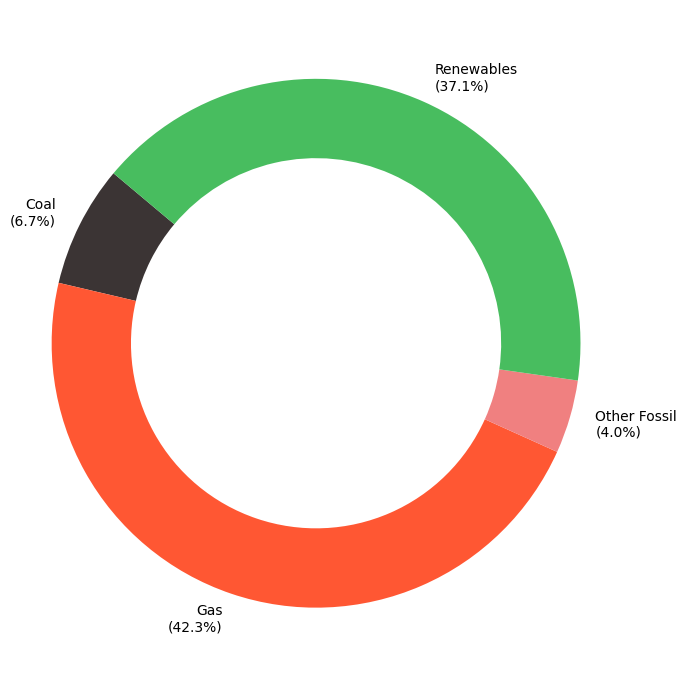

In [10]:
pastel_colors = {
    "Coal": "#3B3434",  # Coal - less vibrant gray
    "Gas": "#FF5733",  # Gas - less vibrant orange
    "Net Import": "#8648BD",  # Net Import - less vibrant blue
    "Other Fossil": "#F08080",  # Other Fossil - less vibrant red
    "Renewables": "#48BD5F",  # Renewables - less vibrant green
}
# print(fuel_mix_eirgrid)
# Mapping the pastel colors to the dataframe's FieldName
pastel_pie_colors = [
    pastel_colors[field] for field in df["FieldName"]
]
# Filter df based on net_import_status
if net_import_status == "importing":
    pie_data = df
elif net_import_status == "exporting":
    pie_data = df[df["FieldName"] != "Net Import"]
    # Update pastel_pie_colors to match the filtered data
    pastel_pie_colors = [pastel_colors[field] for field in pie_data["FieldName"]]

# Generate custom_labels from the (potentially filtered) pie_data
custom_labels = [
    f'{row["FieldName"]}\n({row["Percentage"]:.1f}%)'
    for index, row in pie_data.iterrows()
]
plt.figure(figsize=(7, 7))
plt.pie(
    pie_data["Percentage"],
    labels=custom_labels,
    startangle=140,
    colors=pastel_pie_colors,
    wedgeprops=dict(width=0.3),
)
plt.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.tight_layout()
# plt.show()
# Save the plot to a BytesIO buffer
buf = BytesIO()
plt.savefig(buf, format="png")
buf.seek(0)
plt.show()

In [12]:
df

,EffectiveTime,FieldName,Region,Value,ValueForPercentage,Percentage
0,27-Feb-2024 00:00:00,Coal,ALL,8222.31,8222.31,6.711899
1,27-Feb-2024 00:00:00,Gas,ALL,51852.59,51852.59,42.327439
2,27-Feb-2024 00:00:00,Net Import,ALL,-11567.20,0.00,0.000000
3,27-Feb-2024 00:00:00,Other Fossil,ALL,4954.84,4954.84,4.044652
4,27-Feb-2024 00:00:00,Renewables,ALL,45456.05,45456.05,37.105922


In [15]:
filtered_df = fuel_mix_eirgrid[fuel_mix_eirgrid['FieldName'] != "Net Import"]


In [16]:
filtered_df

,EffectiveTime,FieldName,Region,Value,ValueForPercentage,Percentage
0,27-Feb-2024 00:00:00,Coal,ALL,8222.31,8222.31,6.711899
1,27-Feb-2024 00:00:00,Gas,ALL,51852.59,51852.59,42.327439
3,27-Feb-2024 00:00:00,Other Fossil,ALL,4954.84,4954.84,4.044652
4,27-Feb-2024 00:00:00,Renewables,ALL,45456.05,45456.05,37.105922


In [12]:
fuel_mix_details

'- Coal: 8222.31 MWh (6.7%)\n- Gas: 51852.59 MWh (42.3%)\n- Net Import: -11567.2 MWh (0.0%)\n- Other Fossil: 4954.84 MWh (4.0%)\n- Renewables: 45456.05 MWh (37.1%)'

In [14]:
df

,EffectiveTime,FieldName,Region,Value,ValueForPercentage,Percentage
0,27-Feb-2024 00:00:00,Coal,ALL,8222.31,8222.31,6.711899
1,27-Feb-2024 00:00:00,Gas,ALL,51852.59,51852.59,42.327439
2,27-Feb-2024 00:00:00,Net Import,ALL,-11567.20,0.00,0.000000
3,27-Feb-2024 00:00:00,Other Fossil,ALL,4954.84,4954.84,4.044652
4,27-Feb-2024 00:00:00,Renewables,ALL,45456.05,45456.05,37.105922


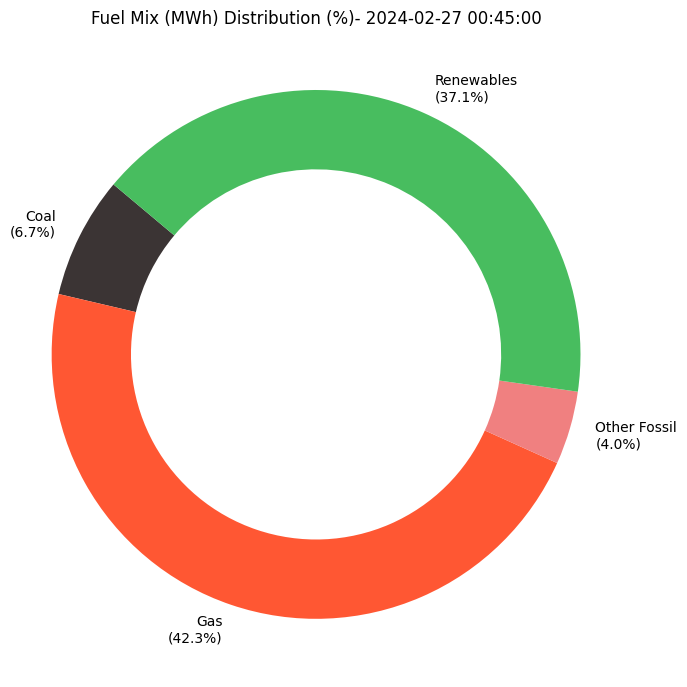

In [13]:
pie_chart_fuel_mix(df,'exporting',now)

In [11]:
def pie_chart_fuel_mix(df, net_import_status, current_time):

    # Adjusting colors to be less vibrant (more pastel-like)
    pastel_colors = {
        "Coal": "#3B3434",  # Coal - less vibrant gray
        "Gas": "#FF5733",  # Gas - less vibrant orange
        "Net Import": "#8648BD",  # Net Import - less vibrant blue
        "Other Fossil": "#F08080",  # Other Fossil - less vibrant red
        "Renewables": "#48BD5F",  # Renewables - less vibrant green
    }
    # print(fuel_mix_eirgrid)
    # Mapping the pastel colors to the dataframe's FieldName
    pastel_pie_colors = [pastel_colors[field] for field in df["FieldName"]]
    # Filter df based on net_import_status
    if net_import_status == "importing":
        pie_data = df
    elif net_import_status == "exporting":
        pie_data = df[df["FieldName"] != "Net Import"]
        # Update pastel_pie_colors to match the filtered data
        pastel_pie_colors = [pastel_colors[field] for field in pie_data["FieldName"]]

    # Generate custom_labels from the (potentially filtered) pie_data
    custom_labels = [
        f'{row["FieldName"]}\n({row["Percentage"]:.1f}%)'
        for index, row in pie_data.iterrows()
    ]
    plt.figure(figsize=(7, 7))
    plt.pie(
        pie_data["Percentage"],
        labels=custom_labels,
        startangle=140,
        colors=pastel_pie_colors,
        wedgeprops=dict(width=0.3),
    )
    plt.title(f"Fuel Mix (MWh) Distribution (%)- {current_time}")
    plt.axis("equal")  # Equal aspect ratio ensures that pie is drawn as a circle.
    plt.tight_layout()
    # plt.show()
    # Save the plot to a BytesIO buffer
    buf = BytesIO()
    plt.savefig(buf, format="png")
    buf.seek(0)
    plt.show()


In [16]:
from subs.energy_api import *
now = round_time(datetime.datetime.now())

# Start time (same time yesterday, rounded to the nearest 15 minutes)
yesterday = now - datetime.timedelta(days=1)
startDateTime = format_date(yesterday)

# End time (current time, rounded to the nearest 15 minutes)
endDateTime = format_date(now)

# call API to get fuel mix for current time
fuel_mix_eirgrid = eirgrid_api("fuelMix", "ALL", startDateTime, startDateTime)


In [14]:
endDateTime

'16-mar-2024+17%3A00'

In [3]:
fuel_mix_eirgrid

,EffectiveTime,FieldName,Region,Value
0,16-Mar-2024 16:30:00,FUEL_COAL,ALL,3057.62
1,16-Mar-2024 16:30:00,FUEL_GAS,ALL,52226.39
2,16-Mar-2024 16:30:00,FUEL_NET_IMPORT,ALL,6953.67
3,16-Mar-2024 16:30:00,FUEL_OTHER_FOSSIL,ALL,4510.56
4,16-Mar-2024 16:30:00,FUEL_RENEW,ALL,48651.90


In [12]:
now = round_time(datetime.datetime.now())

# Start time (same time yesterday, rounded to the nearest 15 minutes)


startDateTime = format_date(datetime.datetime(now.year, now.month, now.day, 0, 0, 0))

# End time (current time, rounded to the nearest 15 minutes)
endDateTime = format_date(now)

wind_for_today=eirgrid_api(
    "windactual", "ALL", startDateTime, endDateTime
)

In [13]:
wind_for_today

,EffectiveTime,FieldName,Region,Value
0,16-Mar-2024 00:00:00,WIND_ACTUAL,ALL,617.0
1,16-Mar-2024 00:15:00,WIND_ACTUAL,ALL,710.0
2,16-Mar-2024 00:30:00,WIND_ACTUAL,ALL,755.0
3,16-Mar-2024 00:45:00,WIND_ACTUAL,ALL,831.0
4,16-Mar-2024 01:00:00,WIND_ACTUAL,ALL,957.0
...,...,...,...,...
64,16-Mar-2024 16:00:00,WIND_ACTUAL,ALL,3056.0
65,16-Mar-2024 16:15:00,WIND_ACTUAL,ALL,3018.0
66,16-Mar-2024 16:30:00,WIND_ACTUAL,ALL,2988.0
67,16-Mar-2024 16:45:00,WIND_ACTUAL,ALL,2891.0


In [7]:
# data is availble every 30 minutes, so we need to start at the nearest half-hour
def round_down_time(dt):
    # Round down to the nearest half-ho/ur
    new_minute = 30 if dt.minute >= 30 else 0
    return dt.replace(minute=new_minute, second=0, microsecond=0)

# Current date and time
now = datetime.datetime.now()
# Round down to the nearest half-hour
start_time = round_down_time(now)
# For end time, let's use 24 hours from now
end_time = now.replace(
    hour=23, minute=59, second=59, microsecond=0
)  # now + timedelta(days=1)

In [9]:
end_time

datetime.datetime(2024, 3, 16, 23, 59, 59)

In [22]:
def today_time():
    """Generate start and end date and time strings for today's data reading.

    Returns:
        Tuple[str, str]: A tuple containing the start date and time string
        formatted as 'YYYY-MM-DD HH:MM:SS' and the end date and time string
        formatted as 'YYYY-MM-DD HH:MM:SS'.
    """
    now = round_time(datetime.datetime.now())

    # Start time of today
    startDateTime = format_date(
        datetime.datetime(now.year, now.month, now.day, 0, 0, 0)
    )

    # End time (current time, rounded to the nearest 15 minutes)
    endDateTime = format_date(now)

    return (startDateTime, endDateTime)

In [27]:
startDateTime, endDateTime = today_time()


demand_for_today = eirgrid_api("demandactual", "ALL", startDateTime,endDateTime)


In [28]:
demand_for_today

,EffectiveTime,FieldName,Region,Value
0,16-Mar-2024 00:00:00,SYSTEM_DEMAND,ALL,4396.0
1,16-Mar-2024 00:15:00,SYSTEM_DEMAND,ALL,4356.0
2,16-Mar-2024 00:30:00,SYSTEM_DEMAND,ALL,4281.0
3,16-Mar-2024 00:45:00,SYSTEM_DEMAND,ALL,4206.0
4,16-Mar-2024 01:00:00,SYSTEM_DEMAND,ALL,4139.0
...,...,...,...,...
65,16-Mar-2024 16:15:00,SYSTEM_DEMAND,ALL,5137.0
66,16-Mar-2024 16:30:00,SYSTEM_DEMAND,ALL,5211.0
67,16-Mar-2024 16:45:00,SYSTEM_DEMAND,ALL,5187.0
68,16-Mar-2024 17:00:00,SYSTEM_DEMAND,ALL,5206.0


In [ ]:
def 

In [29]:
# Convert 'EffectiveTime' to datetime and set as index
demand_for_today["EffectiveTime"] = pd.to_datetime(
    demand_for_today["EffectiveTime"], format="%d-%b-%Y %H:%M:%S"
)
demand_for_today_indexed = demand_for_today.set_index(
    "EffectiveTime"
)

last_value_index_demand = demand_for_today_indexed[
    "Value"
].last_valid_index()

# Select rows up to the row before the last NaN
df_demand_recent = demand_for_today_indexed.loc[
    :last_value_index_demand
]

df_demand_recent["Value"] = df_demand_recent[
    "Value"
].interpolate()

/var/folders/n8/5rf_2zc91lx1ffhm5t27hrsw0000gn/T/ipykernel_2130/3212117684.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_demand_recent["Value"] = df_demand_recent[


In [30]:
df_demand_recent

,FieldName,Region,Value
EffectiveTime,,,
2024-03-16 00:00:00,SYSTEM_DEMAND,ALL,4396.0
2024-03-16 00:15:00,SYSTEM_DEMAND,ALL,4356.0
2024-03-16 00:30:00,SYSTEM_DEMAND,ALL,4281.0
2024-03-16 00:45:00,SYSTEM_DEMAND,ALL,4206.0
2024-03-16 01:00:00,SYSTEM_DEMAND,ALL,4139.0
...,...,...,...
2024-03-16 16:00:00,SYSTEM_DEMAND,ALL,5108.0
2024-03-16 16:15:00,SYSTEM_DEMAND,ALL,5137.0
2024-03-16 16:30:00,SYSTEM_DEMAND,ALL,5211.0


In [25]:
startDateTime, endDateTime = today_time()


In [26]:
startDateTime

'16-mar-2024+00%3A00'

In [1]:
from subs.energy_api import *
from subs.openai_script import *

demand = actual_demand_cal()

/Users/saeed/Documents/GitHub/telegram-energy-api/subs/energy_api.py:533: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_data_frame["Value"] = recent_data_frame["Value"].interpolate()


In [2]:
wind = wind_gen_cal()

/Users/saeed/Documents/GitHub/telegram-energy-api/subs/energy_api.py:533: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recent_data_frame["Value"] = recent_data_frame["Value"].interpolate()


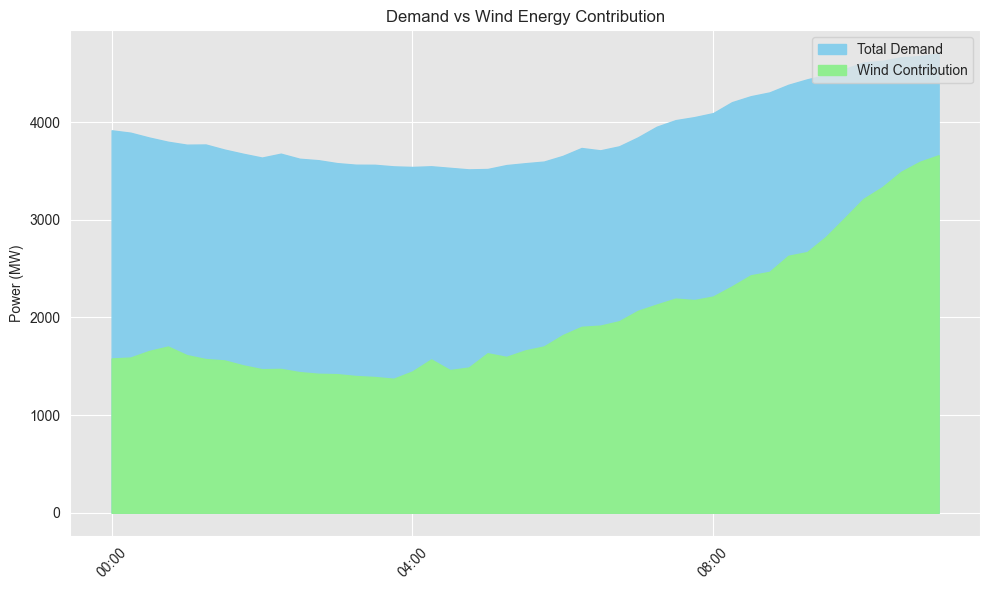

In [3]:
demand_stats = calculate_stats_wind_demand(demand)
wind_stats = calculate_stats_wind_demand(wind)
plot_demand_vs_wind = area_plot_wind_demand(demand, wind)

In [4]:
create_wind_demand_prompt(demand_stats,wind_stats)

"As of today, the performance of the electricity system is summarized as follows:\n\n- ⚡ **Electricity Demand**: The average demand was 3917.64 MW, with a minimum of 3516.0 MW recorded at 04:45 and a maximum of 4704.0 MW observed at 11:00.\n- 🌬️ **Wind Generation**: In terms of wind generation, the average output stood at 2017.09 MW. The lowest generation reached 1372.0 MW at 03:45, while the peak generation was 3661.0 MW at 11:00.\n- 💨 **Wind's Contribution**: On average, wind generation has contributed 51.49% of the total electricity demand.\n\nThis report highlights the power system's dynamics from the start of today until now, emphasizing the significant contribution of wind 🍃 to meeting the electricity demand."

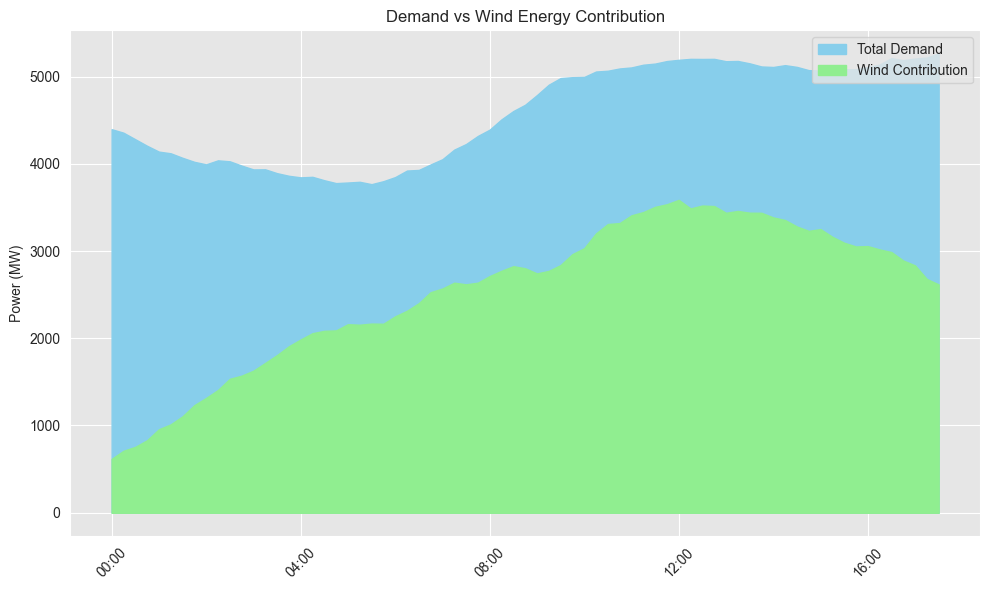

In [4]:
area_plot_wind_demand(demand,wind)

In [6]:
wind

,FieldName,Region,Value
EffectiveTime,,,
2024-03-16 00:00:00,WIND_ACTUAL,ALL,617.0
2024-03-16 00:15:00,WIND_ACTUAL,ALL,710.0
2024-03-16 00:30:00,WIND_ACTUAL,ALL,755.0
2024-03-16 00:45:00,WIND_ACTUAL,ALL,831.0
2024-03-16 01:00:00,WIND_ACTUAL,ALL,957.0
...,...,...,...
2024-03-16 16:15:00,WIND_ACTUAL,ALL,3018.0
2024-03-16 16:30:00,WIND_ACTUAL,ALL,2988.0
2024-03-16 16:45:00,WIND_ACTUAL,ALL,2891.0


In [7]:
demand

,FieldName,Region,Value
EffectiveTime,,,
2024-03-16 00:00:00,SYSTEM_DEMAND,ALL,4396.0
2024-03-16 00:15:00,SYSTEM_DEMAND,ALL,4356.0
2024-03-16 00:30:00,SYSTEM_DEMAND,ALL,4281.0
2024-03-16 00:45:00,SYSTEM_DEMAND,ALL,4206.0
2024-03-16 01:00:00,SYSTEM_DEMAND,ALL,4139.0
...,...,...,...
2024-03-16 16:15:00,SYSTEM_DEMAND,ALL,5137.0
2024-03-16 16:30:00,SYSTEM_DEMAND,ALL,5211.0
2024-03-16 16:45:00,SYSTEM_DEMAND,ALL,5187.0


In [11]:
combined

,Demand,Wind
EffectiveTime,,
2024-03-16 00:00:00,4396.0,617.0
2024-03-16 00:15:00,4356.0,710.0
2024-03-16 00:30:00,4281.0,755.0
2024-03-16 00:45:00,4206.0,831.0
2024-03-16 01:00:00,4139.0,957.0
...,...,...
2024-03-16 16:15:00,5137.0,3018.0
2024-03-16 16:30:00,5211.0,2988.0
2024-03-16 16:45:00,5187.0,2891.0


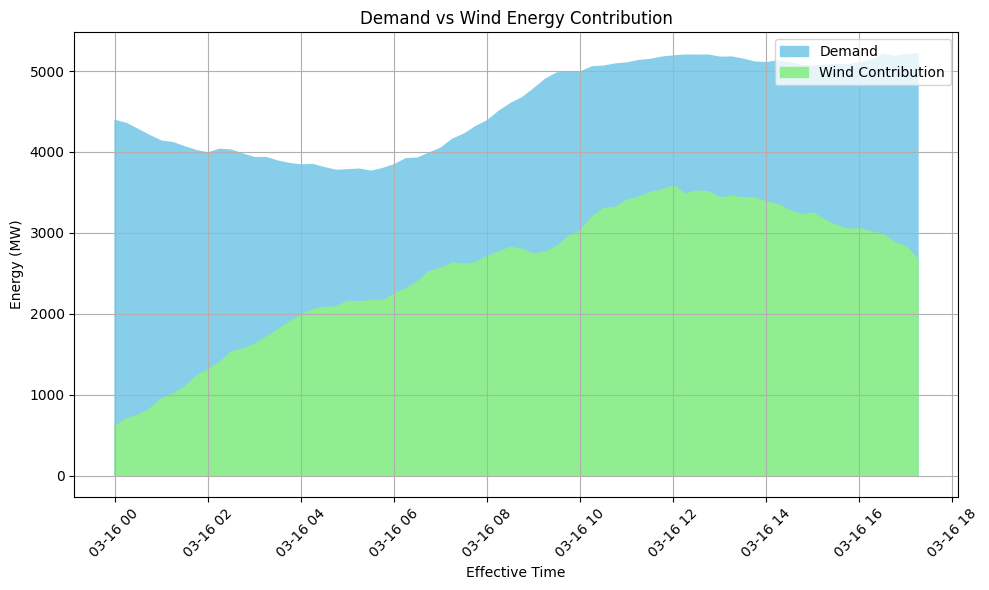

In [8]:

import pandas as pd
import matplotlib.pyplot as plt



# Align DataFrames based on index
combined = pd.DataFrame({
    "Demand": demand["Value"],
    "Wind": wind["Value"]
})

# Plotting
plt.figure(figsize=(10, 6))
plt.fill_between(combined.index, combined["Demand"], label="Demand", color="skyblue")
plt.fill_between(combined.index, combined["Wind"], label="Wind Contribution", color="lightgreen")
plt.title("Demand vs Wind Energy Contribution")
plt.ylabel("Energy (MW)")
plt.xlabel("Effective Time")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()

plt.show()

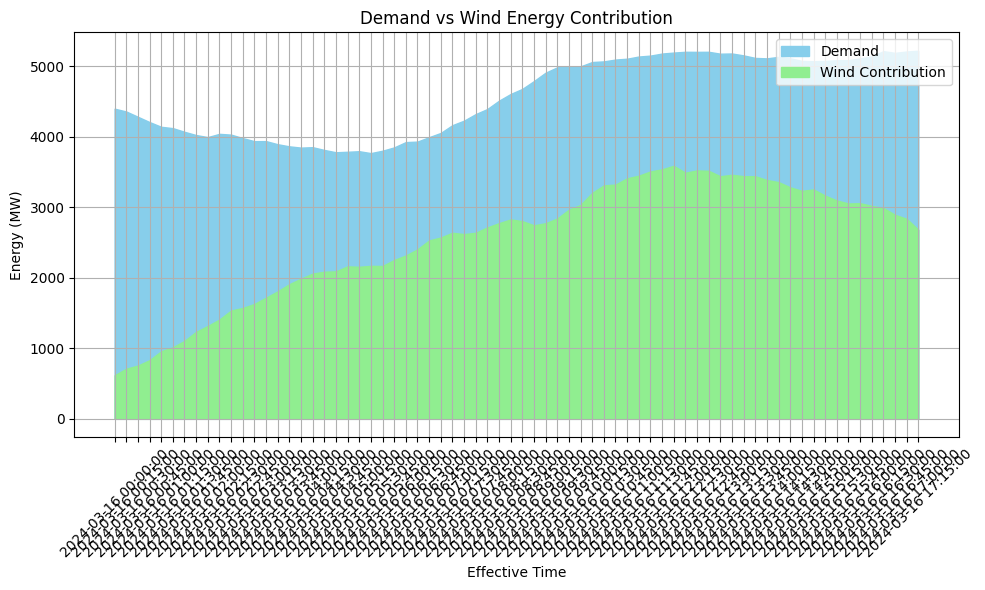

In [12]:
# Plot using a corrected approach
plt.figure(figsize=(10, 6))
x_axis = range(len(combined))  # Use a simple numeric x-axis
plt.fill_between(x_axis, combined["Demand"], label="Demand", color="skyblue")
plt.fill_between(x_axis, combined["Wind"], label="Wind Contribution", color="lightgreen")
plt.xticks(x_axis, combined.index, rotation=45)  # Assuming 'Time' is your adjusted index
plt.title("Demand vs Wind Energy Contribution")
plt.ylabel("Energy (MW)")
plt.xlabel("Effective Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

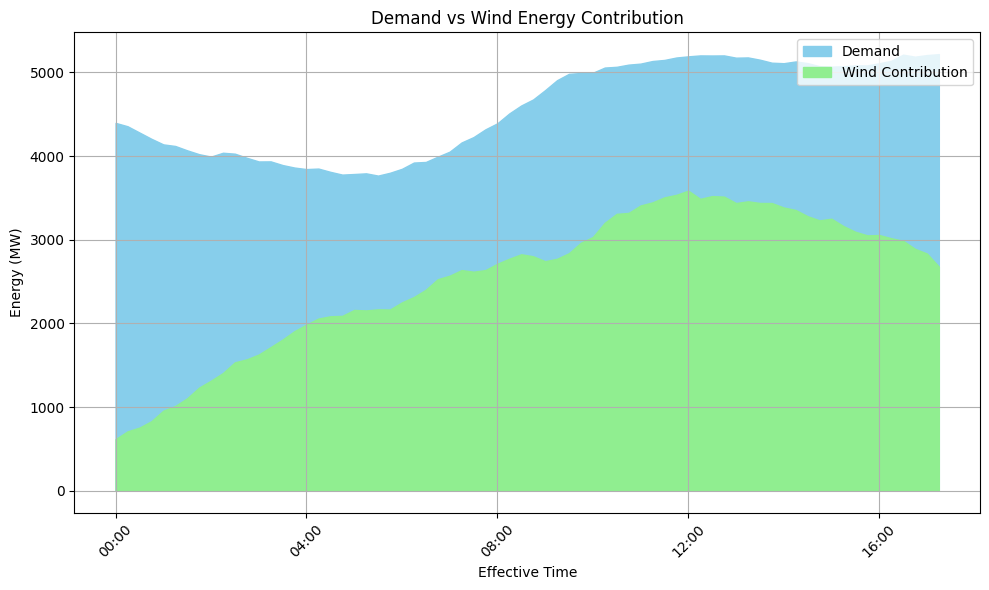

In [13]:
# Correcting the interval calculation
combined_clean = combined.dropna()
# Calculate the number of entries that would constitute a 4-hour span, considering the data's time frequency
time_diff_in_hours = (combined_clean.index[1] - combined_clean.index[0]).seconds / 3600
entries_per_hour = 1 / time_diff_in_hours
four_hourly_entries = int(entries_per_hour * 4)

# Ensure we have a positive, non-zero interval
four_hourly_entries = max(four_hourly_entries, 1)

# Adjust x-ticks and labels for 4-hour intervals
x_ticks = range(0, len(combined_clean), four_hourly_entries)
x_labels = [time.strftime('%H:%M') for i, time in enumerate(combined_clean.index) if i % four_hourly_entries == 0]

# Plotting with the corrected interval
plt.figure(figsize=(10, 6))
plt.fill_between(x_axis, combined_clean["Demand"], label="Demand", color="skyblue")
plt.fill_between(x_axis, combined_clean["Wind"], label="Wind Contribution", color="lightgreen")

plt.xticks(x_ticks, x_labels, rotation=45)  # Setting custom x-ticks based on the correction
plt.title("Demand vs Wind Energy Contribution")
plt.ylabel("Energy (MW)")
plt.xlabel("Effective Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
